This is experiment of DBSCAN using implementation in the sklearn library of Python
The purpose of this experiment is to observe the performance of DBSCAN
- In term of time complexity
- In term of cluster identification

In [56]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
df = pd.read_json('singapore_buildings_fraction.json')
df.rename({'LATITUDE': 'lat', 'LONGTITUDE': 'lon'}, inplace=True)
coords = df.as_matrix(columns=['lat', 'lon'])
df.head()

,ADDRESS,BLK_NO,BUILDING,lat,LONGITUDE,lon,POSTAL,ROAD_NAME,SEARCHVAL,X,Y
0,1 STRAITS BOULEVARD SINGAPORE CHINESE CULTURAL...,1,SINGAPORE CHINESE CULTURAL CENTRE,1.275829,103.849576,103.849576,18906,STRAITS BOULEVARD,SINGAPORE CHINESE CULTURAL CENTRE,29809.365407,28700.236127
1,5A MARINA GARDENS DRIVE SINGAPORE 018910,5A,NIL,1.279587,103.868956,103.868956,18910,MARINA GARDENS DRIVE,5A MARINA GARDENS DRIVE SINGAPORE 018910,31966.120787,29115.753373
2,100A CENTRAL BOULEVARD TEMPORARY SITE OFFICE S...,100A,TEMPORARY SITE OFFICE,1.273682,103.860075,103.860075,18915,CENTRAL BOULEVARD,TEMPORARY SITE OFFICE,30977.832467,28462.795296
3,21 PARK STREET DBS Marina Bay MRT Station SING...,21,DBS Marina Bay MRT Station,1.276427,103.854598,103.854598,18925,PARK STREET,DBS Marina Bay MRT Station,30368.205612,28766.381902
4,21 PARK STREET MARINA BAY MRT STATION SINGAPOR...,21,MARINA BAY MRT STATION,1.276427,103.854598,103.854598,18925,PARK STREET,MARINA BAY MRT STATION,30368.205642,28766.381872


Clustering of this 100 buildings below

In [90]:
KMS_PER_RADIAN = 6371

# convert the neighborhood size to radian 
# i.e. in this case 50m since we taking a very small sample of 100 buildings
epsilon = 0.05 / KMS_PER_RADIAN 

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 65


Finding centroids

In [91]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (1.27582919242, 103.849576389)
1     (1.27958678751, 103.868955674)
2     (1.27368177267, 103.860075469)
3     (1.27642735477, 103.854597777)
4     (1.27631114382, 103.854604975)
5     (1.27625146424, 103.855447156)
6     (1.27524127939, 103.853658961)
7     (1.27773021966, 103.850405709)
8     (1.27493906951, 103.855330339)
9     (1.27535833153, 103.867027808)
10    (1.27737235072, 103.852844801)
11     (1.27790633865, 103.85285165)
12     (1.27709868233, 103.85233293)
13    (1.28071923548, 103.856004677)
14      (1.280137241, 103.856254432)
15    (1.27004058408, 103.857348027)
16       (1.26602231, 103.860527877)
17    (1.26606178744, 103.860559987)
18    (1.27102703612, 103.862447516)
19    (1.27990588518, 103.870469616)
20    (1.28172976578, 103.861684352)
21     (1.2840215005, 103.864915787)
22      (1.28458858839, 103.8646566)
23    (1.28387301464, 103.865993693)
24     (1.2846204628, 103.864735377)
25    (1.28053324159, 103.864832057)
26     (1.28300901487, 103.86664318)
2

In [92]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)
rs.head()

,ADDRESS,BLK_NO,BUILDING,lat,LONGITUDE,lon,POSTAL,ROAD_NAME,SEARCHVAL,X,Y
0,1 STRAITS BOULEVARD SINGAPORE CHINESE CULTURAL...,1,SINGAPORE CHINESE CULTURAL CENTRE,1.275829,103.849576,103.849576,18906,STRAITS BOULEVARD,SINGAPORE CHINESE CULTURAL CENTRE,29809.365407,28700.236127
1,5A MARINA GARDENS DRIVE SINGAPORE 018910,5A,NIL,1.279587,103.868956,103.868956,18910,MARINA GARDENS DRIVE,5A MARINA GARDENS DRIVE SINGAPORE 018910,31966.120787,29115.753373
2,100A CENTRAL BOULEVARD TEMPORARY SITE OFFICE S...,100A,TEMPORARY SITE OFFICE,1.273682,103.860075,103.860075,18915,CENTRAL BOULEVARD,TEMPORARY SITE OFFICE,30977.832467,28462.795296
3,21 PARK STREET DBS Marina Bay MRT Station SING...,21,DBS Marina Bay MRT Station,1.276427,103.854598,103.854598,18925,PARK STREET,DBS Marina Bay MRT Station,30368.205612,28766.381902
4,21 PARK STREET MARINA BAY MRT STATION SINGAPOR...,21,MARINA BAY MRT STATION,1.276311,103.854605,103.854605,18925,PARK STREET,MARINA BAY MRT STATION,30369.006866,28753.531902


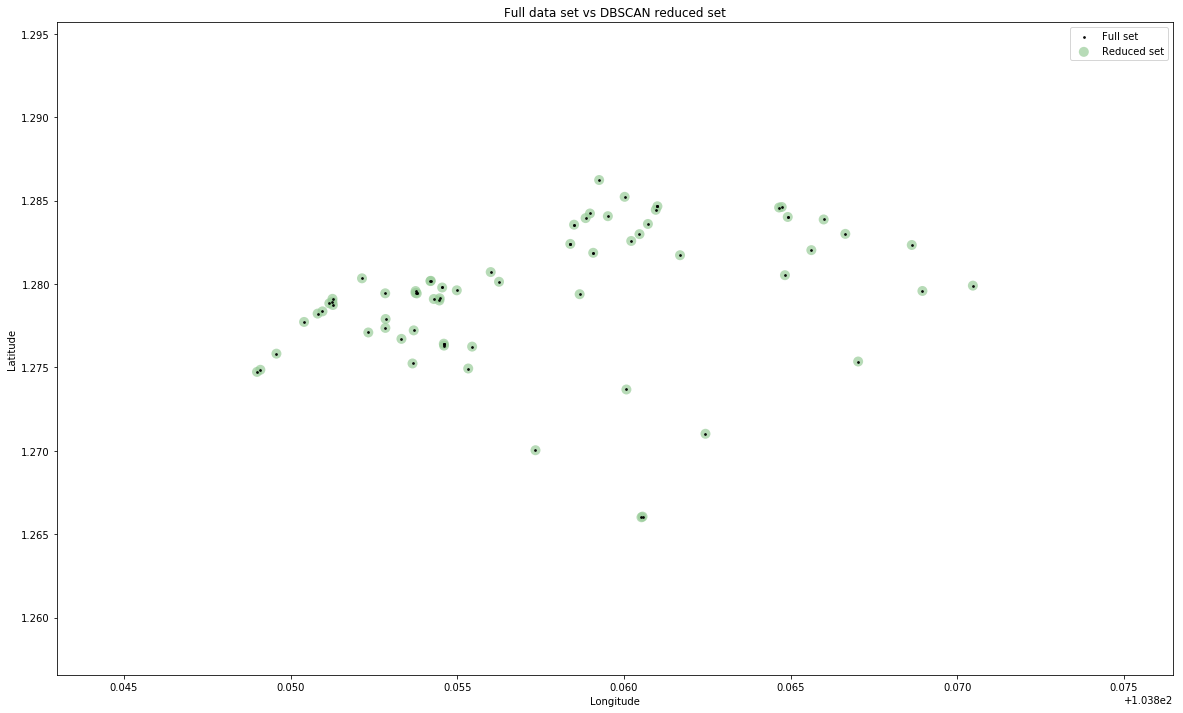

In [93]:
fig, ax = plt.subplots(figsize=[20, 12])

rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=100)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()